In [1]:
# !pip install -U sentence_transformers torch wandb python-dotenv

In [7]:
from datasets import DatasetDict
from torch.utils.data import DataLoader
import torch
import math
from sentence_transformers import SentenceTransformer, LoggingHandler, losses, util, InputExample
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
import logging
from datetime import datetime
import os
import gzip
import csv
import matplotlib.pyplot as plt

#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
#### /print debug information to stdout

#Check if dataset exsist. If not, download and extract  it
sts_dataset_path = 'datasets/stsbenchmark.tsv.gz'

if not os.path.exists(sts_dataset_path):
    util.http_get('https://sbert.net/datasets/stsbenchmark.tsv.gz', sts_dataset_path)

In [4]:
import wandb
from dotenv import load_dotenv
load_dotenv()

True

In [5]:
wandb.login() # relies on WANDB_API_KEY env var
run = wandb.init(
    project="ea-forum-analysis", job_type="training"
)

wandb: Currently logged in as: vpetukhov. Use `wandb login --relogin` to force relogin


In [8]:
art = run.use_artifact("post_pairs:latest")
data = DatasetDict.load_from_disk(art.download())
data

wandb: Downloading large artifact post_pairs:latest, 403.55MB. 7 files... 
wandb:   7 of 7 files downloaded.  
Done. 0:0:18.4


DatasetDict({
    train: Dataset({
        features: ['src_text', 'dst_text', 'src_post_id', 'dst_post_id', 'sims'],
        num_rows: 174991
    })
    dev: Dataset({
        features: ['src_text', 'dst_text', 'src_post_id', 'dst_post_id', 'sims'],
        num_rows: 4220
    })
})

In [72]:
# Read the dataset
# model_name = 'nli-distilroberta-base-v2'
model_name = 'all-MiniLM-L6-v2'
train_batch_size = 256
num_epochs = 1
model_save_path = 'output/training_stsbenchmark_continue_training-'+model_name+'-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


# Load a pre-trained sentence transformer model
model = SentenceTransformer(model_name).cuda()

train_samples = [InputExample(texts=ts, label=float(l)) for ts,l in zip(zip(data['train']['src_text'], data['train']['dst_text']), data['train']['sims'])]
evaluator = EmbeddingSimilarityEvaluator(data['dev']['src_text'], data['dev']['dst_text'], data['dev']['sims'], batch_size=512)

# train_samples = []
# dev_samples = []
# test_samples = []
# with gzip.open(sts_dataset_path, 'rt', encoding='utf8') as fIn:
#     reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
#     for row in reader:
#         score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1
#         inp_example = InputExample(texts=[row['sentence1'], row['sentence2']], label=score)

#         if row['split'] == 'dev':
#             dev_samples.append(inp_example)
#         elif row['split'] == 'test':
#             test_samples.append(inp_example)
#         else:
#             train_samples.append(inp_example)

# train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
# train_loss = losses.CosineSimilarityLoss(model=model)

2022-11-23 17:00:08 - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2022-11-23 17:00:08 - Use pytorch device: cuda


In [9]:
# Development set: Measure correlation between cosine score and gold labels
# logging.info("Read STSbenchmark dev dataset")
# evaluator = EmbeddingSimilarityEvaluator.from_input_examples(dev_samples, name='sts-dev')

2022-11-23 15:00:14 - Read STSbenchmark dev dataset


In [39]:
evaluator(model)

2022-11-23 16:43:32 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset:
2022-11-23 16:43:52 - Cosine-Similarity :	Pearson: 0.6034	Spearman: 0.5573
2022-11-23 16:43:52 - Manhattan-Distance:	Pearson: 0.6100	Spearman: 0.5580
2022-11-23 16:43:52 - Euclidean-Distance:	Pearson: 0.6106	Spearman: 0.5573
2022-11-23 16:43:52 - Dot-Product-Similarity:	Pearson: 0.6034	Spearman: 0.5573


0.5580159339745571

## Suggested SBERT training

In [14]:
# Configure the training. We skip evaluation in this example
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logging.info("Warmup-steps: {}".format(warmup_steps))


# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=1,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=model_save_path)

model = SentenceTransformer(model_save_path)
test_evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_samples, name='sts-test')
test_evaluator(model, output_path=model_save_path)

2022-11-23 15:01:31 - Warmup-steps: 144


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/360 [00:00<?, ?it/s]

2022-11-23 15:02:12 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-dev dataset after epoch 0:
2022-11-23 15:02:14 - Cosine-Similarity :	Pearson: 0.8882	Spearman: 0.8889
2022-11-23 15:02:14 - Manhattan-Distance:	Pearson: 0.8607	Spearman: 0.8634
2022-11-23 15:02:14 - Euclidean-Distance:	Pearson: 0.8628	Spearman: 0.8663
2022-11-23 15:02:14 - Dot-Product-Similarity:	Pearson: 0.8396	Spearman: 0.8415
2022-11-23 15:02:14 - Save model to output/training_stsbenchmark_continue_training-nli-distilroberta-base-v2-2022-11-23_14-58-46
2022-11-23 15:02:20 - Load pretrained SentenceTransformer: output/training_stsbenchmark_continue_training-nli-distilroberta-base-v2-2022-11-23_14-58-46
2022-11-23 15:02:21 - Use pytorch device: cuda
2022-11-23 15:02:21 - EmbeddingSimilarityEvaluator: Evaluating the model on sts-test dataset:
2022-11-23 15:02:23 - Cosine-Similarity :	Pearson: 0.8589	Spearman: 0.8582
2022-11-23 15:02:23 - Manhattan-Distance:	Pearson: 0.8262	Spearman: 0.8288
2022-11-23 15:02:

0.858169904173178

## Weighting layer

### Decompose

In [ ]:
model = SentenceTransformer(model_name)
train_loss = losses.CosineSimilarityLoss(model=model)

2022-11-23 14:55:10 - Load pretrained SentenceTransformer: nli-distilroberta-base-v2
2022-11-23 14:55:11 - Use pytorch device: cuda


In [33]:
t_features, t_labs = next(iter(train_dataloader))
pred_sims = torch.cosine_similarity(
    model(t_features[0])['sentence_embedding'], 
    model(t_features[1])['sentence_embedding']
)

In [69]:
pred_sims = torch.cosine_similarity(
    model[1](model[0](t_features[0]))['sentence_embedding'],
    model[1](model[0](t_features[1]))['sentence_embedding']
)

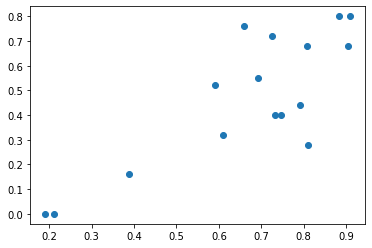

In [70]:
plt.scatter(pred_sims.detach().numpy(), t_labs.detach().numpy())

### New pooling class

In [13]:
from tqdm.notebook import tqdm
import numpy as np

In [192]:
from torch import Tensor, nn
from typing import Dict


class WPooling(nn.Module):
    def __init__(self, word_embedding_dimension: int):
        super(WPooling, self).__init__()
        self.word_embedding_dimension = word_embedding_dimension
        self.pooling_output_dimension = word_embedding_dimension
        self.weight_layer = nn.Linear(word_embedding_dimension, 1, bias=True)
        self.sigma_layer = nn.ReLU()


    def forward(self, features: Dict[str, Tensor]):
        token_embeddings = features['token_embeddings']
        attention_mask = features['attention_mask']

        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

        masked_embeddings = (token_embeddings * input_mask_expanded)
        token_weights = self.sigma_layer(self.weight_layer(masked_embeddings))
        # token_weights = torch.zeros_like(masked_embeddings) + 1

        weighted_masked_embeddings = token_weights * masked_embeddings

        sum_embeddings = torch.sum(weighted_masked_embeddings, 1)

        sum_mask = (token_weights * input_mask_expanded).sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)

        output_vector = sum_embeddings / sum_mask
        features.update({
            'sentence_embedding': output_vector, 'token_weights': token_weights,
            'masked_embeddings': masked_embeddings, 'input_mask_expanded': input_mask_expanded,
            'sum_embeddings': sum_embeddings, 'sum_mask': sum_mask, 'weighted_masked_embeddings': weighted_masked_embeddings
        })
        return features

    # def forward(self, features: Dict[str, Tensor]):
    #     token_embeddings = features['token_embeddings']
    #     attention_mask = features['attention_mask']

    #     input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    #     sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)

    #     sum_mask = input_mask_expanded.sum(1)
    #     sum_mask = torch.clamp(sum_mask, min=1e-9)

    #     output_vector = sum_embeddings / sum_mask
    #     features.update({'sentence_embedding': output_vector})
    #     return features

    def get_sentence_embedding_dimension(self):
        return self.pooling_output_dimension

In [175]:
# tr = model_weighted(X[0])

In [176]:
# tr['token_weights'][1, 2]

In [174]:
# tr['weighted_masked_embeddings'][1, 2, :]

In [173]:
# tr['masked_embeddings'][1, 2, :] * tr['token_weights'][1, 2]

In [193]:
train_batch_size = 128

In [201]:
model = SentenceTransformer(model_name)
model_raw = SentenceTransformer(
    modules = [model[0], WPooling(model[0].get_word_embedding_dimension())]
).cuda()

for p in model_raw[0].parameters():
    p.requires_grad = False

2022-11-23 18:02:53 - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2022-11-23 18:02:53 - Use pytorch device: cuda
2022-11-23 18:02:53 - Use pytorch device: cuda


In [203]:
evaluator(model_raw)

2022-11-23 18:03:17 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset:
2022-11-23 18:03:37 - Cosine-Similarity :	Pearson: 0.4582	Spearman: 0.4289
2022-11-23 18:03:37 - Manhattan-Distance:	Pearson: 0.2996	Spearman: 0.3261
2022-11-23 18:03:37 - Euclidean-Distance:	Pearson: 0.2966	Spearman: 0.3244
2022-11-23 18:03:37 - Dot-Product-Similarity:	Pearson: 0.3580	Spearman: 0.3797


0.428904590376042

```
2022-11-23 18:03:17 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset:
2022-11-23 18:03:37 - Cosine-Similarity :	Pearson: 0.4582	Spearman: 0.4289
2022-11-23 18:03:37 - Manhattan-Distance:	Pearson: 0.2996	Spearman: 0.3261
2022-11-23 18:03:37 - Euclidean-Distance:	Pearson: 0.2966	Spearman: 0.3244
2022-11-23 18:03:37 - Dot-Product-Similarity:	Pearson: 0.3580	Spearman: 0.3797
```

In [196]:
evaluator(model)

2022-11-23 17:52:40 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset:
2022-11-23 17:52:59 - Cosine-Similarity :	Pearson: 0.6034	Spearman: 0.5573
2022-11-23 17:52:59 - Manhattan-Distance:	Pearson: 0.6100	Spearman: 0.5580
2022-11-23 17:52:59 - Euclidean-Distance:	Pearson: 0.6106	Spearman: 0.5573
2022-11-23 17:52:59 - Dot-Product-Similarity:	Pearson: 0.6034	Spearman: 0.5573


0.5580159339745571

In [197]:
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)
train_dataloader.collate_fn = model_raw.smart_batching_collate
# train_loss_w = losses.CosineSimilarityLoss(model=model_weighted)

In [198]:
def emb_similarity(output):
    embeddings = [r['sentence_embedding'] for r in output]
    return torch.cosine_similarity(embeddings[0], embeddings[1])

#### Profile training

In [102]:
import numpy as np

In [103]:
train_loader2 = DataLoader([(t.texts, np.float32(t.label)) for t in train_samples], shuffle=True, batch_size=train_batch_size)

In [77]:
# model_weighted[0].tokenize([x.texts for x in train_samples[:10]])

- Total: 24s
- Tokenize: 3s
- Forward pass + Tokenize: 24s
- BERT pass + Tokenize: 23s

In [115]:
optimizer = torch.optim.SGD(model_weighted[1].weight_layer.parameters(), lr=1e-3)
c_loss = nn.MSELoss()

for batch, (X, y) in enumerate(tqdm(train_loader2)):

        X = [{k: v.to('cuda') for k,v in model_weighted[0].tokenize(t).items()} for t in X]
        y = y.to('cuda')

        res = [model_weighted[0](sentence_feature) for sentence_feature in X]

        # sim = emb_similarity(res)

        # # sparsity_loss = (res[0]['token_weights'] / res[0]['token_weights'].max()).sum()# + res[1]['token_weights'].sum()

        # loss = c_loss(sim, y.view(-1))# + sparsity_loss * 1e-4

        # # loss = train_loss_w(X, y)

        # # Backpropagation
        # optimizer.zero_grad()
        # loss.backward()
        # optimizer.step()
        
        if batch > 20:
            break

  0%|          | 0/684 [00:00<?, ?it/s]

In [111]:
print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=5))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  Source Location                                            
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------------------  
                                  cudaStreamSynchronize        77.59%     604.146ms        77.59%     604.146ms      86.307ms           0 b           0 b           0 b           0 b             7                                 

#### Normal training

In [207]:
import copy
model_weighted = copy.deepcopy(model_raw)

In [208]:
# optimizer = torch.optim.SGD(model_weighted[1].weight_layer.parameters(), lr=1e-1)
optimizer = torch.optim.Adam(model_weighted[1].weight_layer.parameters(), lr=0.05)

c_loss = nn.MSELoss()

for batch, (X, y) in enumerate(tqdm(train_dataloader)):
    X = [{k: v.to('cuda') for k,v in fs.items()} for fs in X]
    y = y.cuda()

    res = [model_weighted(sentence_feature) for sentence_feature in X]
    sim = emb_similarity(res)

    # sparsity_loss = (res[0]['token_weights'] / res[0]['token_weights'].max()).sum()# + res[1]['token_weights'].sum()

    loss = c_loss(sim, y.view(-1))# + sparsity_loss * 1e-4

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (batch > 0) and (batch % 100 == 0):
        # break
        evaluator(model_weighted)
    
    # if batch >= 200:
    #     break

  0%|          | 0/1368 [00:00<?, ?it/s]

2022-11-23 18:08:40 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset:
2022-11-23 18:09:00 - Cosine-Similarity :	Pearson: 0.5974	Spearman: 0.5507
2022-11-23 18:09:00 - Manhattan-Distance:	Pearson: 0.4088	Spearman: 0.4407
2022-11-23 18:09:00 - Euclidean-Distance:	Pearson: 0.4045	Spearman: 0.4395
2022-11-23 18:09:00 - Dot-Product-Similarity:	Pearson: 0.5464	Spearman: 0.5167
2022-11-23 18:10:02 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset:
2022-11-23 18:10:22 - Cosine-Similarity :	Pearson: 0.5995	Spearman: 0.5586
2022-11-23 18:10:22 - Manhattan-Distance:	Pearson: 0.4158	Spearman: 0.4410
2022-11-23 18:10:22 - Euclidean-Distance:	Pearson: 0.3933	Spearman: 0.4391
2022-11-23 18:10:22 - Dot-Product-Similarity:	Pearson: 0.5468	Spearman: 0.5250
2022-11-23 18:11:24 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset:
2022-11-23 18:11:44 - Cosine-Similarity :	Pearson: 0.6012	Spearman: 0.5630
2022-11-23 18:11:44 - Manhattan-Distance:	Pearson: 0.4170	S

In [209]:
evaluator(model_weighted)

2022-11-23 18:26:31 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset:
2022-11-23 18:26:50 - Cosine-Similarity :	Pearson: 0.6306	Spearman: 0.5948
2022-11-23 18:26:50 - Manhattan-Distance:	Pearson: 0.3880	Spearman: 0.3861
2022-11-23 18:26:50 - Euclidean-Distance:	Pearson: 0.3330	Spearman: 0.3672
2022-11-23 18:26:50 - Dot-Product-Similarity:	Pearson: 0.4693	Spearman: 0.5176


0.5948078534110832

In [210]:
evaluator(model)

2022-11-23 18:26:51 - EmbeddingSimilarityEvaluator: Evaluating the model on  dataset:
2022-11-23 18:27:10 - Cosine-Similarity :	Pearson: 0.6034	Spearman: 0.5573
2022-11-23 18:27:10 - Manhattan-Distance:	Pearson: 0.6100	Spearman: 0.5580
2022-11-23 18:27:10 - Euclidean-Distance:	Pearson: 0.6106	Spearman: 0.5573
2022-11-23 18:27:10 - Dot-Product-Similarity:	Pearson: 0.6034	Spearman: 0.5573


0.5580159339745571

## Investigate results

In [ ]:
from pandas import DataFrame

: 

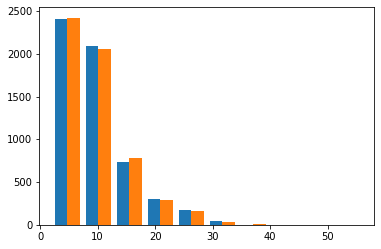

In [ ]:
n_words_per_text = np.array([[len(t.split()) for t in ts.texts] for ts in train_samples])
plt.hist(n_words_per_text);

In [245]:
long_ids = np.where(n_words_per_text.max(axis=1) > 30)[0]

In [292]:
# t_ex = train_samples[long_ids[0]].texts
# inps = [model_weighted.tokenize(t) for t in t_ex]
# preds = [model_weighted({k: v.to('cuda') for k,v in inp.items()}) for inp in inps]

In [341]:
t_ex = train_samples[long_ids[2]]
inps = [model_weighted[0].tokenizer.encode_plus(t, return_tensors='pt').to('cuda') for t in t_ex.texts]
preds = [model_weighted(inp) for inp in inps]
emb_similarity(preds)[0].item(), t_ex.label

(0.8304498195648193, 0.8400000000000001)

In [342]:
weights = preds[0]['token_weights'].squeeze().detach().cpu().numpy()
DataFrame(dict(
    token=model_weighted[0].tokenizer.tokenize(t_ex.texts[0], add_special_tokens=True), 
    weight=weights / weights.max()
))

,token,weight
0,<s>,0.004005
1,r,0.008981
2,ussia,0.047740
3,Ġratified,0.012617
4,Ġthe,0.001319
5,Ġupdated,0.007120
6,Ġtreaty,0.002397
7,Ġin,0.006770
8,Ġ2004,0.013473
9,Ġbut,0.016851


In [262]:
model_weighted[0].tokenizer.decode(inps[0])

TypeError: Can't convert {'input_ids': [[0, 506, 2], [0, 257, 2], [0, 462, 2], [0, 705, 2], [0, 118, 2], [0, 139, 2], [0, 2, 1], [0, 428, 2], [0, 242, 2], [0, 338, 2], [0, 571, 2], [0, 298, 2], [0, 242, 2], [0, 462, 2], [0, 462, 2], [0, 102, 2], [0, 2, 1], [0, 29, 2], [0, 90, 2], [0, 102, 2], [0, 90, 2], [0, 242, 2], [0, 417, 2], [0, 2, 1], [0, 90, 2], [0, 298, 2], [0, 102, 2], [0, 90, 2], [0, 2, 1], [0, 90, 2], [0, 298, 2], [0, 242, 2], [0, 2, 1], [0, 417, 2], [0, 118, 2], [0, 571, 2], [0, 118, 2], [0, 90, 2], [0, 102, 2], [0, 462, 2], [0, 2, 1], [0, 605, 2], [0, 139, 2], [0, 338, 2], [0, 119, 2], [0, 2, 1], [0, 282, 2], [0, 102, 2], [0, 119, 2], [0, 242, 2], [0, 417, 2], [0, 2, 1], [0, 29, 2], [0, 1343, 2], [0, 2, 1], [0, 298, 2], [0, 242, 2], [0, 462, 2], [0, 462, 2], [0, 2, 1], [0, 605, 2], [0, 102, 2], [0, 29, 2], [0, 2, 1], [0, 642, 2], [0, 102, 2], [0, 338, 2], [0, 90, 2], [0, 118, 2], [0, 438, 2], [0, 257, 2], [0, 462, 2], [0, 102, 2], [0, 338, 2], [0, 462, 2], [0, 219, 2], [0, 2, 1], [0, 705, 2], [0, 118, 2], [0, 338, 2], [0, 257, 2], [0, 462, 2], [0, 242, 2], [0, 282, 2], [0, 90, 2], [0, 2, 1], [0, 102, 2], [0, 282, 2], [0, 417, 2], [0, 2, 1], [0, 338, 2], [0, 242, 2], [0, 642, 2], [0, 462, 2], [0, 118, 2], [0, 438, 2], [0, 102, 2], [0, 90, 2], [0, 242, 2], [0, 417, 2], [0, 2, 1], [0, 118, 2], [0, 90, 2], [0, 29, 2], [0, 242, 2], [0, 462, 2], [0, 506, 2], [0, 2, 1], [0, 102, 2], [0, 90, 2], [0, 2, 1], [0, 90, 2], [0, 298, 2], [0, 242, 2], [0, 2, 1], [0, 338, 2], [0, 102, 2], [0, 90, 2], [0, 242, 2], [0, 2, 1], [0, 139, 2], [0, 506, 2], [0, 2, 1], [0, 398, 2], [0, 288, 2], [0, 288, 2], [0, 288, 2], [0, 2, 1], [0, 90, 2], [0, 118, 2], [0, 119, 2], [0, 242, 2], [0, 29, 2], [0, 2, 1], [0, 102, 2], [0, 282, 2], [0, 2, 1], [0, 298, 2], [0, 139, 2], [0, 257, 2], [0, 338, 2], [0, 4, 2], [0, 2, 1]], 'attention_mask': [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 0], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 0]]} to Sequence

In [254]:
preds[0]['token_weights'][:,:,:]

tensor([[[0.4410],
         [0.4084],
         [0.4127]],

        [[0.5261],
         [0.4620],
         [0.4923]],

        [[0.5091],
         [0.5238],
         [0.4647]],

        [[0.5243],
         [0.5109],
         [0.4907]],

        [[0.5627],
         [0.5200],
         [0.5301]],

        [[0.4686],
         [0.4629],
         [0.4195]],

        [[0.4641],
         [0.4520],
         [0.5063]],

        [[0.4310],
         [0.4204],
         [0.3855]],

        [[0.5197],
         [0.4970],
         [0.4718]],

        [[0.4787],
         [0.4499],
         [0.4380]],

        [[0.4930],
         [0.4623],
         [0.4272]],

        [[0.4905],
         [0.4717],
         [0.4213]],

        [[0.5197],
         [0.4970],
         [0.4718]],

        [[0.5091],
         [0.5238],
         [0.4647]],

        [[0.5091],
         [0.5238],
         [0.4647]],

        [[0.4844],
         [0.4513],
         [0.4277]],

        [[0.4641],
         [0.4520],
         [0.5063]]

In [ ]:
pre

In [151]:
# model_weighted(X[0])['token_weights'].min()

In [152]:
# ((1 - model_weighted(X[0])['token_weights'])).max()

TODO: 
- add mean embedding to the weighter input
- add more layers